Helpers to load `APT_coherence_T` pickles into Python using the installed `rqc` package.

In [1]:
%load_ext autoreload
%autoreload 2

In [99]:
from APT_coherence_T_utils import *

# p_m = p_f 

In [3]:
data_dict = load_apt_coherence(p_f=0, p_f_int=-1, zipfilename='APT_coherence_T.zip',
BATCH_CONFIG = {
    12: {'es_batch': 2000, 'num_batches': 1},
    14: {'es_batch': 2000, 'num_batches': 1},
    16: {'es_batch': 2000, 'num_batches': 1},
    18: {'es_batch': 2000, 'num_batches': 1},
    20: {'es_batch': 2000, 'num_batches': 1},
    22: {'es_batch': 1000, 'num_batches': 2},
    24: {'es_batch': 100, 'num_batches': 20},
})

generate_params:   0%|          | 0/22 [00:00<?, ?it/s]

generate_params: 100%|██████████| 440/440 [00:00<00:00, 1324.76it/s]


In [4]:
data_df = apt_coherence_to_df(data_dict)

In [5]:
data_df

observations
Metrics   L  p_m  p_f es_C es_m                                                   
coherence 12 0.00 0.0 1    1     [906.8074456317959, 2157.4563822796254, 2711.4...
                      2    1     [825.0045057915493, 2289.80864141572, 2909.322...
                      3    1     [916.1432764541145, 2398.846072339343, 2780.80...
                      4    1     [1126.0416346148775, 2177.636681437099, 2793.8...
                      5    1     [1392.2096317665423, 2376.3273486885923, 3000....
...                                                                            ...
          24 0.19 0.0 1996 1     [5146.148525462436, 377288.7240916595, 188371....
                      1997 1     [7432.907420172494, 53423.45497293726, 6273.82...
                      1998 1     [23472.613738804845, 277310.10015821835, 16315...
                      1999 1     [74687.39406702659, 29214.905328052577, 15112....
                      2000 1     [52092.906007654914, 4305.196484429954, 32751....

[308000 rows x 1 columns]

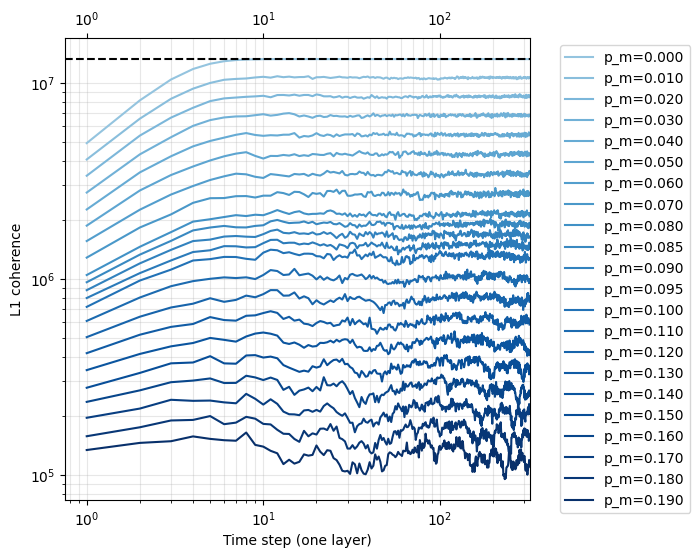

In [6]:
plot_apt_coherence_T_vs_steps(data_df, L=24)

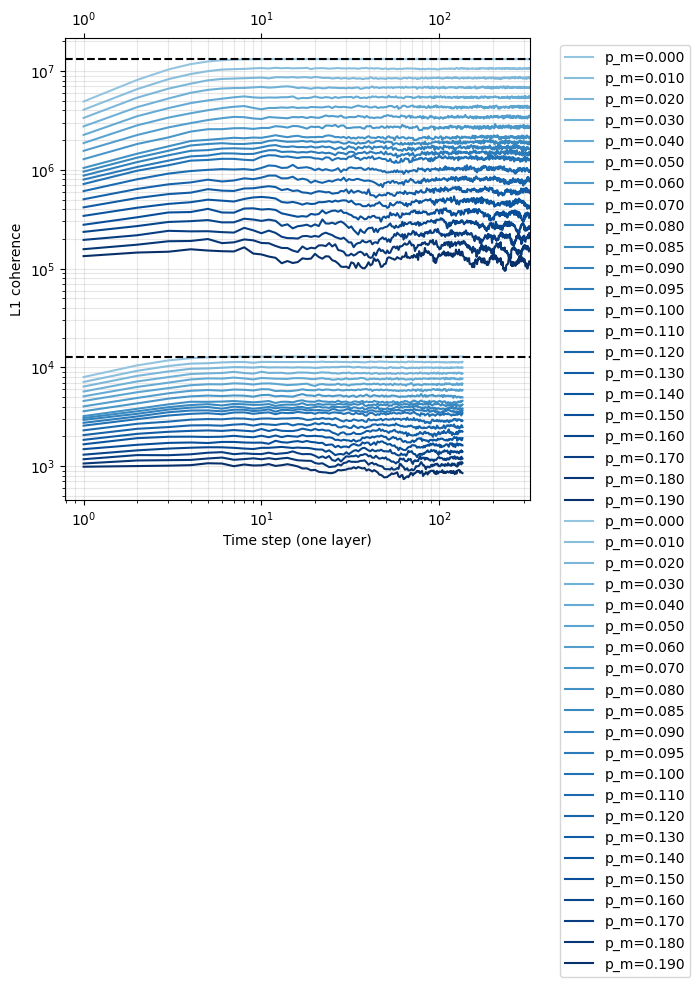

In [169]:
fig, ax =plt.subplots(figsize=(6, 6))   
plot_apt_coherence_T_vs_steps(data_df, L=14, ax=ax)
plot_apt_coherence_T_vs_steps(data_df, L=24, ax=ax)

In [25]:
L_list = np.arange(12,25,2)

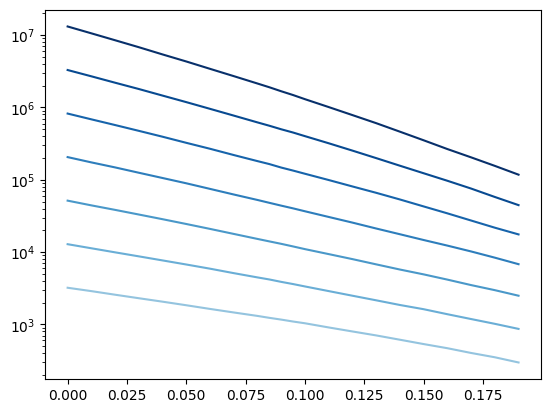

In [172]:
p_m_list = np.round(P_M_VALUES,3)
L_list = data_df.index.get_level_values('L').unique()

fig,ax=plt.subplots()
color_list = plt.cm.Blues(np.linspace(0.4,1,len(L_list)))
for idx,L in enumerate(L_list):
    data = [np.stack(data_df.xs(p_m, level='p_m').xs(L,level='L')['observations']).mean(axis=0)[int(L**1.6):].mean() for p_m in p_m_list]
    ax.plot(p_m_list, data, color=color_list[idx])
ax.set_yscale('log')
    

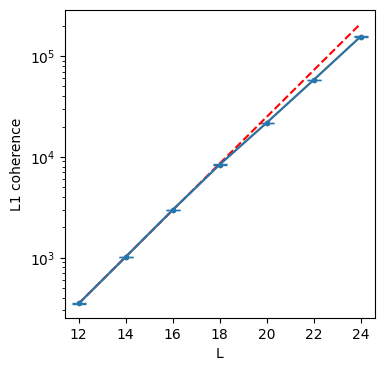

In [199]:
plot_apt_coherence_T_vs_L(data_df, p_m=0.18)

In [197]:
np.sqrt(0.09)

np.float64(0.3)

# p_f =1

In [4]:
os.environ['WORKDIR']="/scratch/hp636/"

In [5]:
!echo $WORKDIR

/scratch/hp636/


In [13]:
data_dict_pf1 = load_apt_coherence(p_f=1, p_f_int=1, zipfilename='APT_coherence_T_pf1.zip',
BATCH_CONFIG = {
    12: {'es_batch': 2000, 'num_batches': 1},
    14: {'es_batch': 2000, 'num_batches': 1},
    16: {'es_batch': 2000, 'num_batches': 1},
    18: {'es_batch': 2000, 'num_batches': 1},
    20: {'es_batch': 2000, 'num_batches': 1},
    22: {'es_batch': 1000, 'num_batches': 2},
    24: {'es_batch': 200, 'num_batches': 10},
},
p_m_list =  np.hstack([np.arange(0, 0.06, 0.02), np.arange(0.06, 0.08, 0.01), np.arange(0.085, 0.101, 0.005),np.arange(0.11, 0.13, 0.01), ])
# p_m_list =  np.hstack([np.arange(0, 0.06, 0.02), np.arange(0.06, 0.08, 0.01), np.arange(0.085, 0.101, 0.005), ])
)

generate_params:   0%|          | 0/13 [00:00<?, ?it/s]

generate_params: 100%|██████████| 130/130 [00:00<00:00, 998.19it/s]


In [14]:
data_pf1_df = apt_coherence_to_df(data_dict_pf1)

In [15]:
data_pf1_df

observations
Metrics   L  p_m  p_f es_C es_m                                                   
coherence 12 0.00 1.0 1    1     [906.8074456317959, 2157.4563822796254, 2711.4...
                      2    1     [825.0045057915493, 2289.80864141572, 2909.322...
                      3    1     [916.1432764541145, 2398.846072339343, 2780.80...
                      4    1     [1126.0416346148775, 2177.636681437099, 2793.8...
                      5    1     [1392.2096317665423, 2376.3273486885923, 3000....
...                                                                            ...
          24 0.13 1.0 1196 1     [99457.57138547671, 353903.0068273285, 1018993...
                      1197 1     [34840.66469518506, 1026180.2568499227, 288410...
                      1198 1     [372739.8140533655, 1358246.9439319852, 82105....
                      1199 1     [354860.1661325354, 172572.04617176607, 105435...
                      1200 1     [67528.49115729326, 1124318.4833972633, 122182...

[173200 rows x 1 columns]

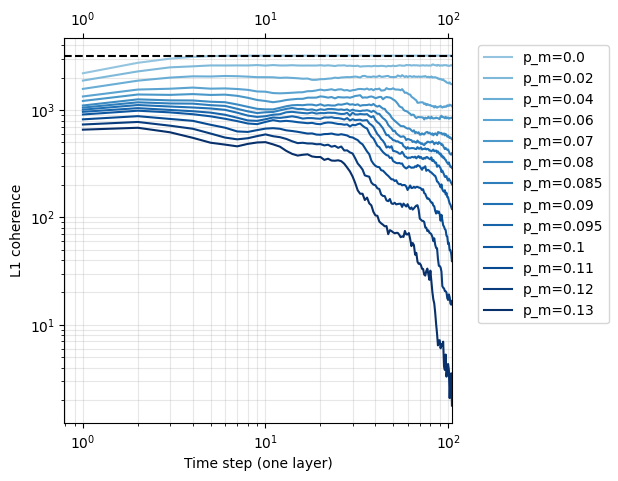

In [53]:
plot_apt_coherence_T_vs_steps(data_pf1_df, fix_ = {'L':12} )
# plt.ylim(1e2,None)

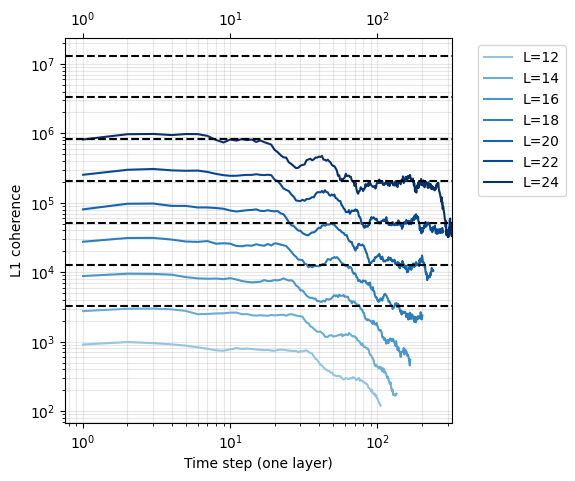

In [61]:
plot_apt_coherence_T_vs_steps(data_pf1_df, fix_ = {'p_m':0.1} )
# plt.ylim(1e2,None)

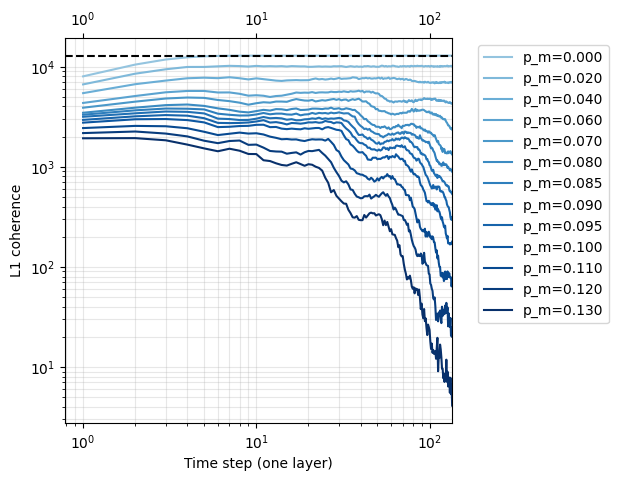

In [21]:
plot_apt_coherence_T_vs_steps(data_pf1_df, L=14)
# plt.ylim(1e2,None)

In [69]:
np.stack(data_pf1_df.xs(0.02, level='p_m').xs(12,level='L')['observations']).shape

(2000, 106)

In [76]:
np.stack(data_df.xs(0.02, level='p_m').xs(12,level='L')['observations'])[:,-1:].shape

(2000, 1)

In [93]:
slice(None)

slice(None, None, None)

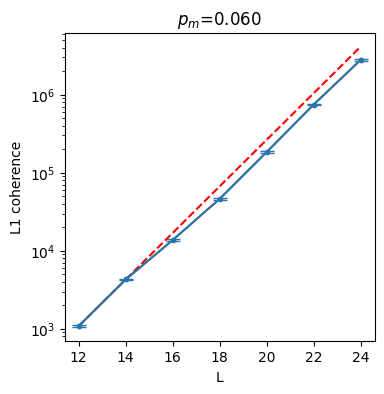

In [117]:
plot_apt_coherence_T_vs_L(data_pf1_df, p_m=0.06, min_func=lambda L: int(2*L**1.6)-1, max_func=lambda L: int(2*L**1.6))

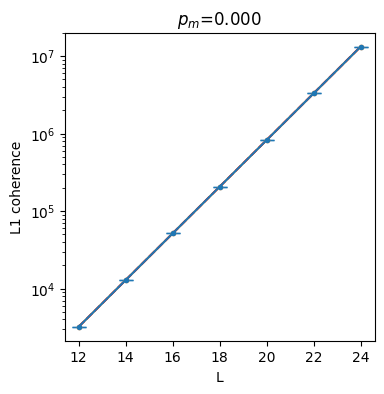

In [120]:
plot_apt_coherence_T_vs_L(data_pf1_df, p_m=0.00, min_func=lambda L: int(2*L**1)-1, max_func=lambda L: int(2*L**1))

In [121]:
260*3/20

39.0

In [ ]:
L_list = [12, 14, 16, 18, 20,22,]

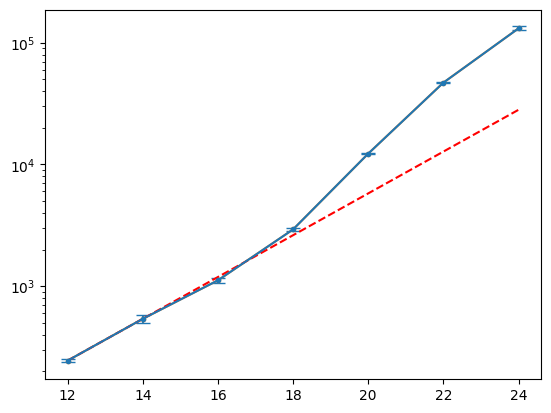

In [121]:
p_m = 0.1
fig, ax =plt.subplots()
x = L_list
y = [np.stack(data_pf1_df.xs(p_m, level='p_m').xs(L,level='L')['observations']).mean(axis=0)[int(L**1.6):].mean() for L in L_list]
yerr = [sem(np.stack(data_pf1_df.xs(p_m, level='p_m').xs(L,level='L')['observations']).mean(axis=0)[int(L**1.6):]) for L in L_list]

# y = [np.stack(data_pf1_df.xs(p_m, level='p_m').xs(L,level='L')['observations']).mean(axis=0)[-1:].mean() for L in L_list]
ax.errorbar(x, y, yerr=yerr, fmt='.-', capsize=5)
ax.set_yscale('log')

# Here I want to use the first two points of "(x,y)", then fit linear in the linear-log scale, and plot it, using numpy,

# Take the first two points
x_fit = x[:2]
y_fit = y[:2]

# Fit a line in linear-log scale
log_y = np.log10(y_fit)
slope, intercept = np.polyfit(x_fit, log_y, 1)

# Create a function for the fitted line
def fitted_line(L):
    return 10**(intercept + slope * L)

# Plot the original data and the fitted line
ax.plot(x, y, '.-')
ax.plot(x, fitted_line(np.array(x)), 'r--')


In [ ]:
k


In [31]:
P_M_VALUES

array([0.   , 0.01 , 0.02 , 0.03 , 0.04 , 0.05 , 0.06 , 0.07 , 0.08 ,
       0.085, 0.09 , 0.095, 0.1  , 0.11 , 0.12 , 0.13 , 0.14 , 0.15 ,
       0.16 , 0.17 , 0.18 , 0.19 ])

Index([  0.0,  0.02,  0.04,  0.06,  0.07,  0.08, 0.085,  0.09, 0.095,   0.1,
        0.11,  0.12,  0.13,  0.14,  0.16,  0.18],
      dtype='float64', name='p_m')

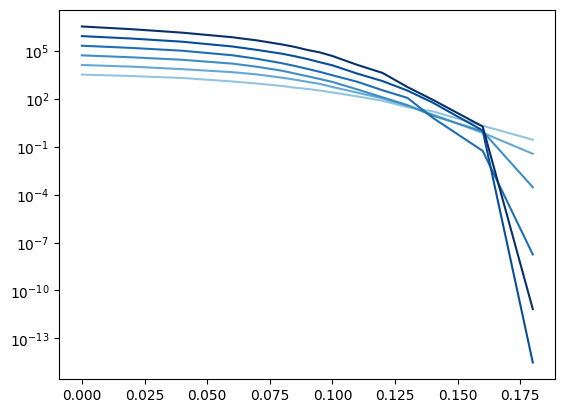

In [74]:
p_m_list = np.round(P_M_VALUES,3)
fig,ax=plt.subplots()
color_list = plt.cm.Blues(np.linspace(0.4,1,len(L_list)))
p_m_list = data_df.index.get_level_values('p_m').unique()
for idx,L in enumerate(L_list):
    data = [np.stack(data_df.xs(p_m, level='p_m').xs(L,level='L')['observations']).mean(axis=0)[int(L**1.6):].mean() for p_m in p_m_list]
    ax.plot(p_m_list, data, color=color_list[idx])
ax.set_yscale('log')
    

# p_f =1 , t_f = 6L^1.6

In [9]:
data_dict_pf1_6L = load_apt_coherence(p_f=1, p_f_int=1, zipfilename='APT_coherence_T_pf1_6L.zip',
BATCH_CONFIG = {
    12: {'es_batch': 2000, 'num_batches': 1},
    14: {'es_batch': 2000, 'num_batches': 1},
    16: {'es_batch': 2000, 'num_batches': 1},
    18: {'es_batch': 2000, 'num_batches': 1},
    20: {'es_batch': 2000, 'num_batches': 1},
    22: {'es_batch': 1000, 'num_batches': 2},
    24: {'es_batch': 200, 'num_batches': 10},
},
p_m_list =  np.hstack([np.arange(0, 0.06, 0.02), np.arange(0.06, 0.08, 0.01), np.arange(0.085, 0.101, 0.005),np.arange(0.11, 0.13, 0.01), ])
)

generate_params:   0%|          | 0/13 [00:00<?, ?it/s]

generate_params: 100%|██████████| 130/130 [00:00<00:00, 304274.29it/s]


In [10]:
data_pf1_df_6L = apt_coherence_to_df(data_dict_pf1_6L)

In [11]:
data_pf1_df_6L

observations
Metrics   L  p_m  p_f es_C es_m                                                   
coherence 12 0.00 1.0 1    1     [906.8074456317973, 2157.45638227963, 2711.435...
                      2    1     [825.004505791548, 2289.8086414157174, 2909.32...
                      3    1     [916.1432764541147, 2398.8460723393423, 2780.8...
                      4    1     [1126.0416346148793, 2177.636681437101, 2793.8...
                      5    1     [1392.2096317665423, 2376.3273486885937, 3000....
...                                                                            ...
          18 0.13 1.0 1996 1     [3728.2446904632475, 13002.591571463212, 20701...
                      1997 1     [1747.2895514384732, 6638.194332937248, 2792.6...
                      1998 1     [3361.6340229571792, 4167.077004164878, 64147....
                      1999 1     [15722.3778750623, 31895.935368976825, 81952.0...
                      2000 1     [14270.352160411567, 10623.17989231118, 11487....

[104000 rows x 1 columns]

In [ ]:
plot_apt_coherence_T_vs_steps(data_pf1_df_6L, L=20)


In [ ]:
k